In [22]:
import requests
from requests.exceptions import HTTPError

import math
import pandas as pd
from decimal import Decimal
from pandas.io.json import json_normalize
import json

import numpy as np
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
from scipy.stats import truncnorm, norm

In [23]:
#Variables/Params
api_key = '46583da07984f6f5e5acc0442fad24656e164280da7811e9aefa8bcfc9d1' #defi pulse

In [24]:
#get json query
def defipulse_getdata(request, api_key):
    try:
        response = requests.get('https://data-api.defipulse.com/api/v1/defipulse/api/' + request +'?api-key=' + api_key + '&period=1y')
        response.raise_for_status()
        # access JSOn content
        return response.json()
        #print("Entire JSON response")
        #print(api_output[0]) #validate response from API

    except HTTPError as http_err:
        return (f'HTTP error occurred: {http_err}')
    except Exception as err:
        return (f'Other error occurred: {err}')

#convert to callable dataframe
def get_lendrates(data):
    df = pd.DataFrame.from_dict(data)
    data = pd.json_normalize(df['lend_rates'])
    data = pd.merge(pd.to_datetime(df['timestamp'],unit='s').dt.date, data, left_index=True, right_index=True)
    data = data.set_index('timestamp')
    return data

In [25]:
#BRL monte carlo Simulkator
#APY data generation (gaussian)
def generate_apy_gauss(value, stdev, var, days):
    lownum = value - var
    highnum = value + var
    def get_truncated_normal(mean, sd, low, upp):
        return truncnorm(
            (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
    X = get_truncated_normal(mean=value, sd=2, low=lownum, upp=highnum)
    return pd.DataFrame(X.rvs(days))

def monte(data,days,trials, apr): #if data is apr()
    #checks if input is dataframe, if not makes it into a dataframe
    data = pd.DataFrame(data)

    #if data is apr it will normalise it to annual, else if data is price it will calc the percentage change
    if apr ==  False:
        log_returns = np.log(1 + data.pct_change()) #calculated daily change
    
    elif True:
        data = data/365
        log_returns = np.log(1 + data)
    
    u = log_returns.mean()
    var = log_returns.var()
    drift = u - (0.5*var)

    stdev = log_returns.std()
    Z = norm.ppf(np.random.rand(days, trials)) #days, trials
    daily_returns = np.exp(drift.values + stdev.values * Z)

    price_paths = np.zeros_like(daily_returns)
    price_paths[0] = data.iloc[-1]
    for t in range(1, days):
        price_paths[t] = price_paths[t-1]*daily_returns[t]
     #prep output into dataframe
    return pd.DataFrame(price_paths)

def joinmonte(df1,df2):
    simulation =  pd.DataFrame()
    for n in range(0,len(df1.columns)):
        simulation[n] = df1[n] + df2[n]
        simulation = simulation.copy()
    return simulation

def generate_apysimdat(basedat, apyvals, stdev,var,days, trials):
    simoutput = pd.DataFrame(columns = ["apy", "pc_loss", "pc_gain"])
    basedat_monte = monte(basedat,days,trials, False)
    simoutput["apy"] = apyvals 
    for n in range(0, len(apyvals)):
        randapydat = generate_apy_gauss(n, stdev, var, days) #generate gaussian 
        randapydat_monte = monte(randapydat,days,trials, True) #generate montecarlo sim for apy
        simulation = joinmonte(basedat_monte, randapydat_monte)
        count_loss = ( sum(1 if x <= simulation.iloc[0,0] else 0 for x in simulation.iloc[(len(simulation)-1),:]) /trials )*100
        count_gain = ( sum(1 if x > simulation.iloc[0,0] else 0 for x in simulation.iloc[(len(simulation)-1),:]) /trials )*100
        simoutput.iloc[n,1] = count_loss
        simoutput.iloc[n,2] = count_gain
    return simoutput

def minmaxmed(data): #dataframe input
    tempdf = pd.DataFrame()
    tempdf['mean'] = data.mean(axis=1)
    tempdf['max'] = data.max(axis=1)
    tempdf['min'] = data.min(axis=1)
    #tempdf['median'] = data.median(axis=1)
    return tempdf



In [26]:
#Fetch Data
################################

#BRL Data
lendingdata = get_lendrates(defipulse_getdata('getLendingHistory',api_key))
brl = pdr.DataReader('DEXBZUS', 'fred')

#normalise datetime and index by date
lendingdata.index.astype('datetime64[ns]')
brl.index.astype('datetime64[ns]')

DatetimeIndex(['2016-08-29', '2016-08-30', '2016-08-31', '2016-09-01',
               '2016-09-02', '2016-09-05', '2016-09-06', '2016-09-07',
               '2016-09-08', '2016-09-09',
               ...
               '2021-08-09', '2021-08-10', '2021-08-11', '2021-08-12',
               '2021-08-13', '2021-08-16', '2021-08-17', '2021-08-18',
               '2021-08-19', '2021-08-20'],
              dtype='datetime64[ns]', name='DATE', length=1300, freq=None)

In [30]:

#####################################
#PARAMS
#####################################
dayperiod = 180
simulation_runs = 500 #more==slower
st_dev = 2
variation = 0.5#+/-

#####################################

#generate brl values for simulation
brl_monte = monte(brl,dayperiod,simulation_runs, False)

#generate apy values for simulation
apy_values = np.arange(0, 10.5, 0.25).tolist()

#generate monte data
brl_monte_data = generate_apysimdat(brl, apy_values,st_dev,variation,dayperiod, simulation_runs)

ranges = minmaxmed(brl_monte) #returns min/max and med ranges.


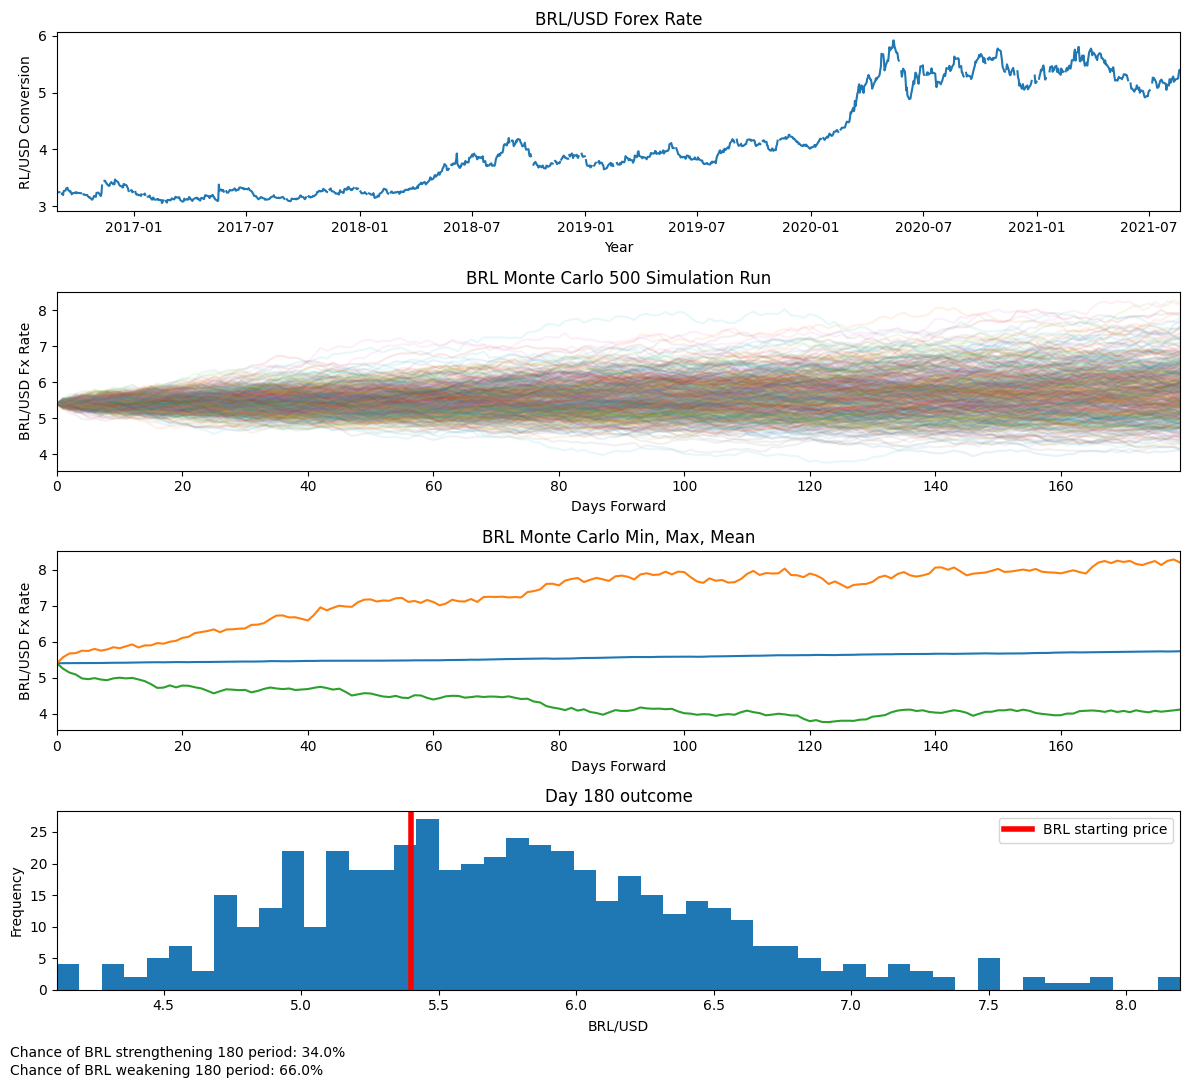

Chance of BRL strengthening 180 period: 34.0%
Chance of BRL weakening 180 period: 66.0%


In [31]:

########################################################################################
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(15, 9))
ax1.plot(brl)
ax1.set(xlabel='Year', ylabel='RL/USD Conversion')
ax1.title.set_text('BRL/USD Forex Rate')
ax1.margins(x=0)

ax2.plot(brl_monte,alpha=0.1)
ax2.set(xlabel='Days Forward', ylabel='BRL/USD Fx Rate')
ax2.title.set_text('BRL Monte Carlo '+str(simulation_runs)+ ' Simulation Run')
ax2.margins(x=0)

ax3.plot(ranges)
ax3.set(xlabel='Days Forward', ylabel='BRL/USD Fx Rate')
ax3.title.set_text('BRL Monte Carlo Min, Max, Mean')
ax3.margins(x=0)

#outcome histogram
ax4.hist(brl_monte.iloc[(len(brl_monte)-1),:],bins=50)
ax4.set(xlabel='BRL/USD', ylabel='Frequency')
ax4.axvline(brl_monte.iloc[0,0],linewidth=4, color='r', label='BRL starting price')
ax4.title.set_text('Day '+ str(dayperiod) + ' outcome')
ax4.legend()
ax4.margins(x=0)
plt.tight_layout(rect=[0, 0.03, .8, 1.2])
fig.text(0.01, 0.02, ("Chance of BRL strengthening " + str(len(brl_monte)) + " period: " + str(( sum(1 if x <= brl_monte.iloc[0,0] else 0 for x in brl_monte.iloc[(len(brl_monte)-1),:]) /simulation_runs )*100) + "%"), ha='left')
fig.text(0.01, 0.0,("Chance of BRL weakening " + str(len(brl_monte)) + " period: " + str(( sum(1 if x > brl_monte.iloc[0,0] else 0 for x in brl_monte.iloc[(len(brl_monte)-1),:]) /simulation_runs )*100) + "%"), ha='left')
plt.show()


#num_brl_montes = int(len(brl_monte.columns()))
count_loss = ( sum(1 if x <= brl_monte.iloc[0,0] else 0 for x in brl_monte.iloc[(len(brl_monte)-1),:]) /simulation_runs )*100
count_gain = ( sum(1 if x > brl_monte.iloc[0,0] else 0 for x in brl_monte.iloc[(len(brl_monte)-1),:]) /simulation_runs )*100
print ("Chance of BRL strengthening " + str(len(brl_monte)) + " period: " + str(count_loss) + "%")
print ("Chance of BRL weakening " + str(len(brl_monte)) + " period: " + str(count_gain) + "%")



####################################
#generate_apysimdat(basedat, apyvals, stdev,var,days, trials)
#brl_monte_data.plot.area(x = 'apy')



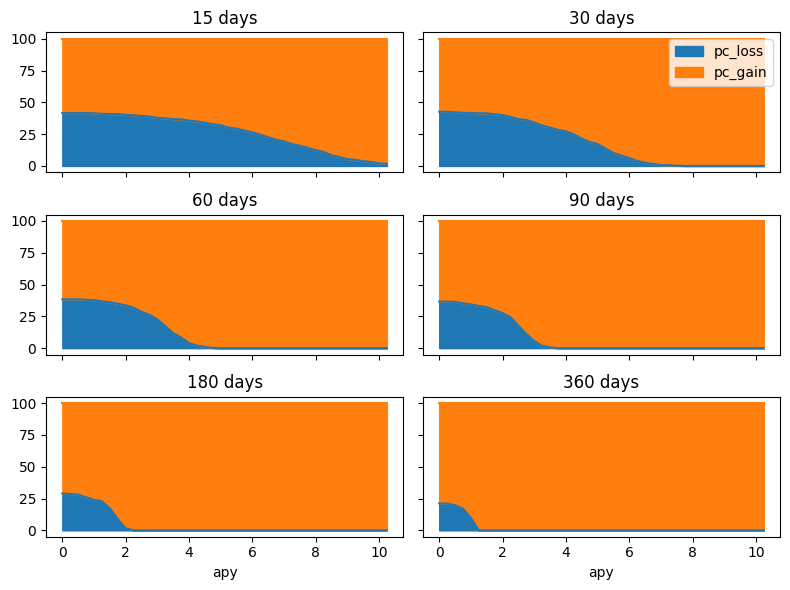

In [32]:
figure, axes = plt.subplots(3, 2,figsize=(8, 5), sharex=True, sharey=True)
generate_apysimdat(brl, apy_values,1,.50,15, simulation_runs).plot.area(x = 'apy',ax=axes[0,0],legend=False,figsize=(8, 6),title='15 days')
generate_apysimdat(brl, apy_values,1,.50,30, simulation_runs).plot.area(x = 'apy',ax=axes[0,1],legend=True,figsize=(8, 6),title='30 days')
generate_apysimdat(brl, apy_values,1,.50,60, simulation_runs).plot.area(x = 'apy',ax=axes[1,0],legend=False,figsize=(8, 6),title='60 days')
generate_apysimdat(brl, apy_values,1,.50,90, simulation_runs).plot.area(x = 'apy',ax=axes[1,1],legend=False,figsize=(8, 6),title='90 days')
generate_apysimdat(brl, apy_values,1,.50,180, simulation_runs).plot.area(x = 'apy',ax=axes[2,0],legend=False,figsize=(8, 6),title='180 days')
generate_apysimdat(brl, apy_values,1,.50,360, simulation_runs).plot.area(x = 'apy',ax=axes[2,1],legend=False,figsize=(8, 6),title='360 days')
plt.tight_layout()


plt.show()


